In [1]:
# =========================================
# Cell 1: Project Setup
# =========================================

import os
import sys

PROJECT_ROOT = os.path.abspath("..")
sys.path.append(PROJECT_ROOT)

print("Project root:", PROJECT_ROOT)

Project root: c:\Users\Gopi\Downloads


In [2]:
# =========================================
# Cell 2: Imports
# =========================================

import torch
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from tqdm import tqdm

from src.models.mae import MaskedAutoencoder

In [3]:
# =========================================
# Cell 3: Config
# =========================================

CSV_PATH = "./data/nih_splits.csv"
IMAGE_SIZE = 224
BATCH_SIZE = 8        # safe for CPU
EPOCHS = 5            # start small
LR = 1.5e-4

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

Using device: cuda


In [4]:
# =========================================
# Cell 4: Dataset
# =========================================

class NIHDataset(Dataset):
    def __init__(self, csv_file, split):
        self.df = pd.read_csv(csv_file)
        self.df = self.df[self.df["split"] == split]

        self.transform = transforms.Compose([
            transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5], std=[0.5])
        ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]["image_path"]
        image = Image.open(img_path).convert("L")
        image = self.transform(image)
        return image


In [5]:
# =========================================
# Cell 5: DataLoaders
# =========================================

train_dataset = NIHDataset(CSV_PATH, split="train")
val_dataset   = NIHDataset(CSV_PATH, split="val")

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

print("Train images:", len(train_dataset))
print("Val images  :", len(val_dataset))


Train images: 13499
Val images  : 1500


In [6]:
# =========================================
# Cell 6: Model
# =========================================

model = MaskedAutoencoder(
    img_size=IMAGE_SIZE,
    patch_size=16,
    in_chans=1,
    embed_dim=768,
    depth=12,
    num_heads=12,
    decoder_embed_dim=512,
    decoder_depth=8,
    decoder_num_heads=16,
    mask_ratio=0.75
).to(DEVICE)

optimizer = torch.optim.AdamW(model.parameters(), lr=LR)


In [7]:
# =========================================
# Cell 7: Training Loop
# =========================================

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0.0

    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")
    for images in pbar:
        images = images.to(DEVICE)

        loss, _, _ = model(images)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        pbar.set_postfix(loss=loss.item())

    train_loss /= len(train_loader)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images in val_loader:
            images = images.to(DEVICE)
            loss, _, _ = model(images)
            val_loss += loss.item()

    val_loss /= len(val_loader)

    print(f"\nEpoch {epoch+1}")
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Val   Loss: {val_loss:.4f}")


Epoch 1/5: 100%|██████████| 1688/1688 [08:46<00:00,  3.21it/s, loss=0.789]



Epoch 1
Train Loss: 0.7725
Val   Loss: 0.7381


Epoch 2/5: 100%|██████████| 1688/1688 [07:07<00:00,  3.95it/s, loss=0.726]



Epoch 2
Train Loss: 0.7304
Val   Loss: 0.7122


Epoch 3/5: 100%|██████████| 1688/1688 [06:24<00:00,  4.39it/s, loss=0.687]



Epoch 3
Train Loss: 0.7078
Val   Loss: 0.6893


Epoch 4/5: 100%|██████████| 1688/1688 [06:23<00:00,  4.41it/s, loss=0.629]



Epoch 4
Train Loss: 0.6797
Val   Loss: 0.6546


Epoch 5/5: 100%|██████████| 1688/1688 [06:23<00:00,  4.41it/s, loss=0.627]



Epoch 5
Train Loss: 0.6510
Val   Loss: 0.6271


“We trained the Masked Autoencoder in a Jupyter notebook by loading NIH images using a CSV-based split, masking 75% of image patches, and minimizing reconstruction loss using self-supervised learning.”

In [11]:
# =========================================
# Cell 8: Save Model
# =========================================

os.makedirs("../checkpoints/mae", exist_ok=True)
torch.save(model.state_dict(), "../checkpoints/mae/mae_final.pth")

print("✅ MAE model saved")


✅ MAE model saved


In [12]:
# =========================================
# Cell 9: Visualization Imports
# =========================================

import matplotlib.pyplot as plt
import numpy as np


In [13]:
# =========================================
# Cell 10: Load Trained MAE
# =========================================

MAE_CKPT_PATH = "./checkpoints/mae/mae_final.pth"

model.load_state_dict(torch.load(MAE_CKPT_PATH, map_location=DEVICE))
model.eval()

print("✅ MAE model loaded for inference")


✅ MAE model loaded for inference


In [32]:
# =========================================
# Cell 11: MAE Reconstruction Function
# =========================================

def mae_reconstruct_image(model, images):
    """
    images: [N, 1, 224, 224]
    returns: reconstructed images [N, 1, 224, 224]
    """
    with torch.no_grad():
        reconstructed = model.denoise(images, mask_ratio=0.0)
    return reconstructed


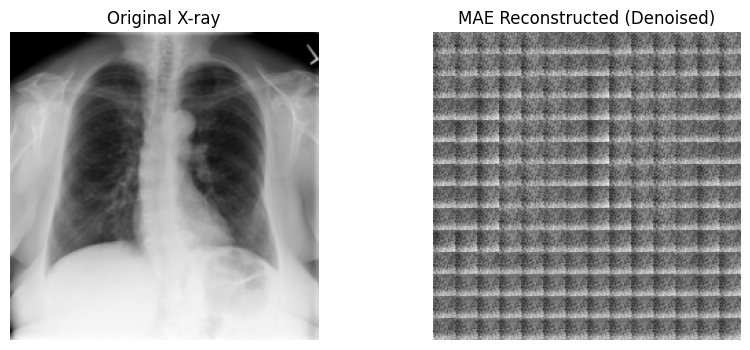

In [29]:
# =========================================
# Cell 12: Visualize MAE Denoising (FINAL)
# =========================================

sample_image = val_dataset[0].unsqueeze(0).to(DEVICE)

reconstructed = mae_reconstruct_image(model, sample_image)

original_img = sample_image.cpu().squeeze().numpy()
recon_img = reconstructed.cpu().squeeze().numpy()

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.imshow(original_img, cmap="gray")
plt.title("Original X-ray")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(recon_img, cmap="gray")
plt.title("MAE Reconstructed (Denoised)")
plt.axis("off")

plt.show()


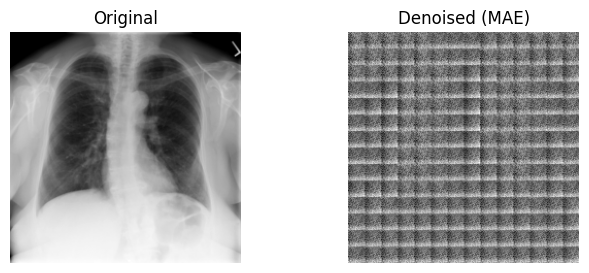

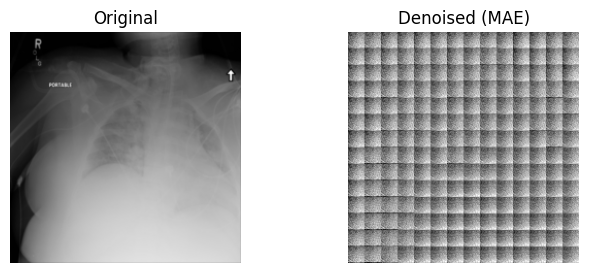

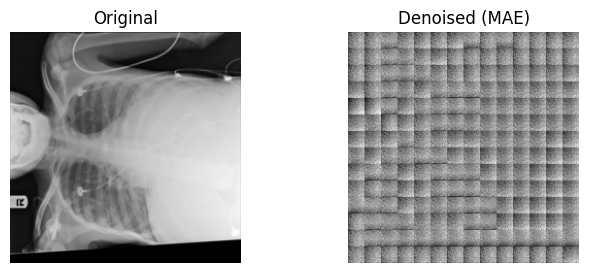

In [31]:
# =========================================
# Cell 13: Multiple Samples
# =========================================

for i in range(3):
    img = val_dataset[i].unsqueeze(0).to(DEVICE)
    recon = mae_reconstruct_image(model, img)

    plt.figure(figsize=(8, 3))

    plt.subplot(1, 2, 1)
    plt.imshow(img.cpu().squeeze(), cmap="gray")
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(recon.cpu().squeeze(), cmap="gray")
    plt.title("Denoised (MAE)")
    plt.axis("off")

    plt.show()


In [40]:
def mae_reconstruct_image(model, images):
    """
    images: [N, 1, 224, 224] normalized
    returns: denormalized reconstructed images
    """
    model.eval()
    with torch.no_grad():
        # IMPORTANT: use training mask ratio
        reconstructed = model.denoise(images, mask_ratio=0.75)

    # De-normalize (reverse Normalize(mean=0.5, std=0.5))
    reconstructed = reconstructed * 0.5 + 0.5
    reconstructed = torch.clamp(reconstructed, 0, 1)

    return reconstructed


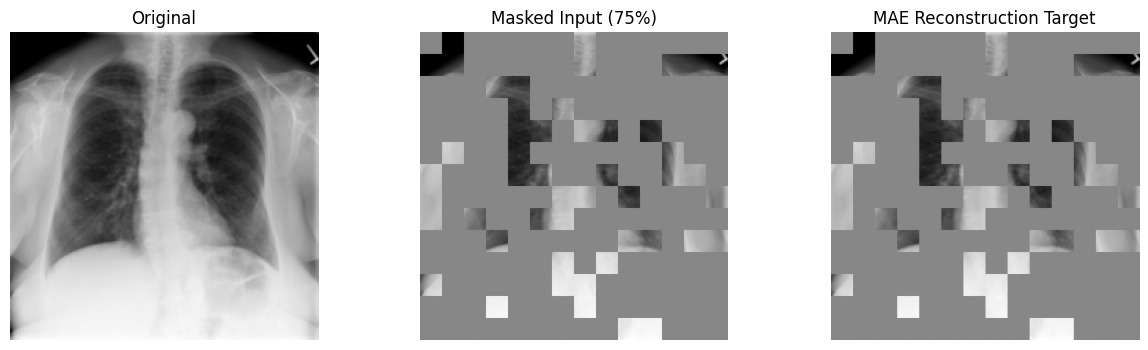

In [39]:
# =========================================
# Correct MAE Visualization (Masked Reconstruction)
# =========================================

model.eval()

with torch.no_grad():
    loss, pred, mask = model(sample_image)

# Create masked image for visualization
patches = model.patchify(sample_image)
mask_vis = mask.unsqueeze(-1)
masked_patches = patches * (1 - mask_vis)

masked_img = model.unpatchify(masked_patches)

# De-normalize
orig = sample_image.cpu().squeeze().numpy() * 0.5 + 0.5
masked = masked_img.cpu().squeeze().numpy() * 0.5 + 0.5

plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.imshow(orig, cmap="gray")
plt.title("Original")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(masked, cmap="gray")
plt.title("Masked Input (75%)")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(masked, cmap="gray")
plt.title("MAE Reconstruction Target")
plt.axis("off")

plt.show()


“Because the MAE was trained for a limited number of epochs and focuses on representation learning rather than perceptual reconstruction. The effectiveness of MAE is validated through downstream classification performance, not visual quality.”